# EMA cross EMA - Trap - Analytics

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896


In [6]:
data["ema_fast"] = ta.ema(data["Close"], length=20)
data["ema_low"] = ta.ema(data["Close"], length=250)
data["ema_cross"] = ((data["ema_fast"] > data["ema_low"]) & (data["ema_fast"].shift(1) <= data["ema_low"].shift(1)) | (data["ema_fast"] < data["ema_low"]) & (data["ema_fast"].shift(1) >= data["ema_low"].shift(1)))

In [7]:
data[data.ema_cross == True]

,Open,High,Low,Close,Volume,ema_fast,ema_low,ema_cross
Date,,,,,,,,
2020-11-09 09:00:00,914.2,915.2,913.8,914.6,2604,909.118854,908.879708,True
2020-11-11 14:10:00,915.2,915.8,912.6,912.6,5683,918.032316,918.540744,True
2020-11-11 14:45:00,921.4,921.4,921.4,921.4,5605,918.822408,918.586590,True
2020-11-16 14:45:00,916.9,916.9,916.9,916.9,3978,926.606152,926.709781,True
2020-11-17 14:15:00,931.2,932.5,930.8,932.2,6138,925.503509,925.322347,True
...,...,...,...,...,...,...,...,...
2025-02-13 13:45:00,1337.2,1338.5,1336.5,1336.9,4460,1334.380176,1334.148219,True
2025-02-18 09:00:00,1335.3,1335.3,1332.8,1333.1,7051,1338.524221,1338.652775,True
2025-02-18 10:30:00,1344.9,1348.3,1344.9,1347.3,10368,1339.283340,1338.512776,True


### Preparing data for detecting TRAP

In [8]:
def cal_max_distance(r):
    if not r['ema_cross']:
        return 0
    if r['ema_fast'] > r['ema_low']:
        the_diff = round(r['ema_fast'] - r['min_emafast_25'])
    else:
        the_diff = round(r['max_emafast_25'] - r['ema_fast'])
    return the_diff
def cal_rsi_moving(r):
    if not r['ema_cross']:
        return 0
    if r['ema_fast'] > r['ema_low']:
        moving_len = r['RSI'] - r['min_5_rsi']
    else:
        moving_len = r['max_5_rsi'] - r['RSI']
    return moving_len

In [9]:
data['max_high_1dlater'] = data['High'].shift(-51).rolling(51).max()
data['min_low_1dlater'] = data['Low'].shift(-51).rolling(51).min()
data['RSI'] = ta.rsi(data["Close"], length=14)
data['RSI'] = round(data['RSI'])
data['min_5_rsi'] = data['RSI'].rolling(6).min()
data['max_5_rsi'] = data['RSI'].rolling(6).max()
data["body_size"] = abs(data["Close"] - data["Open"])
data["low_momentum"] = data["body_size"].rolling(5).mean() < data["body_size"].rolling(20).mean() * 0.5  # Small body filter
data['diff_cema'] = round(data['Close'] - data['ema_low'])
data["avg_volume"] = data["Volume"].rolling(25).mean()  # 1/2 day
data["diff_volume"] = round(data["Volume"] / data["avg_volume"], 1)
data['max_20'] = data['High'].rolling(25).max()
data['min_20'] = data['Low'].rolling(25).min()
data['diff_minmax_20'] = data['max_20'] - data['min_20']
data['diff_minmax_20'] = round(data['diff_minmax_20'])
data['avg_body_size'] = data["body_size"].rolling(5).mean()
data['body_size_on_avg'] = round(data['body_size'] / data['avg_body_size'], 1)
data['diff_ema'] = data['ema_fast'] - data['ema_low']
data["Cross_Speed"] = data["diff_ema"].diff(5) / 5
data["Cross_Speed"] = round(data["Cross_Speed"], 1)
data['max_diff_ema'] = data['diff_ema'].rolling(25).max()
data['max_diff_ema'] = round(data['max_diff_ema'])
data['min_diff_ema'] = data['diff_ema'].rolling(25).min()
data['min_diff_ema'] = round(data['min_diff_ema'])
data['avg_diff_ema'] = data['diff_ema'].rolling(6).mean()
data['avg_diff_ema'] = round(data['avg_diff_ema'], 1)
data['ibs'] = data.apply(lambda x: (0 if (x["High"] == x["Low"]) else round((x["Close"] - x["Low"]) / (x["High"] - x["Low"]), 1)), axis=1)
data['ibs'] = round(data['ibs'], 1)
data['avg_ibs'] = data['ibs'].rolling(5).mean()
data['avg_ibs'] = round(data['avg_ibs'], 1)
data['max_emafast_25'] = data['ema_fast'].rolling(25).max()
data['min_emafast_25'] = data['ema_fast'].rolling(25).min()
data['hour'] = data.index.hour

In [10]:
data.dropna(inplace=True)

In [11]:
data['max_emafast_distance'] = data.apply(lambda r: cal_max_distance(r), axis=1)
data['rsi_moving'] = data.apply(lambda r: cal_rsi_moving(r), axis=1)

In [12]:
def is_trap(r):
    trap = ''
    if r['ema_cross'] == True:
        if r['ema_fast'] > r['ema_low']:
            # Cross up
            if r['min_low_1dlater'] < r['Close'] - 3.5:
                trap = 'yes'
            else:
                trap = 'no'
        else:
            # Cross down
            if r['max_high_1dlater'] > r['Close'] + 3.5:
                trap = 'yes'
            else:
                trap = 'no'
    return trap

In [13]:
data['trap'] = data.apply(lambda r: is_trap(r), axis=1)

In [14]:
data[data.trap == 'yes'].tail(15)

,Open,High,Low,Close,Volume,ema_fast,ema_low,ema_cross,max_high_1dlater,min_low_1dlater,...,min_diff_ema,avg_diff_ema,ibs,avg_ibs,max_emafast_25,min_emafast_25,hour,max_emafast_distance,rsi_moving,trap
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-18 09:05:00,1376.5,1376.5,1374.5,1374.6,5041,1358.840761,1357.982251,True,1376.8,1363.0,...,-7.0,-2.0,0.0,0.3,1358.840761,1351.157796,9,8,16.0,yes
2024-10-31 13:45:00,1342.5,1345.3,1342.2,1343.8,16422,1339.071768,1338.968548,True,1347.8,1333.6,...,-3.0,-0.7,0.5,0.7,1339.071768,1336.131371,13,3,14.0,yes
2024-12-13 09:20:00,1332.5,1332.7,1331.8,1332.3,2805,1338.382557,1338.728614,True,1339.1,1331.7,...,-0.0,1.4,0.6,0.4,1347.718281,1338.382557,9,9,7.0,yes
2024-12-23 09:55:00,1329.2,1329.3,1329.0,1329.1,900,1325.399361,1325.168913,True,1330.5,1322.5,...,-8.0,-0.9,0.3,0.3,1325.399361,1317.060948,9,8,0.0,yes
2024-12-24 09:55:00,1324.1,1324.2,1323.4,1323.6,1288,1325.814110,1325.955694,True,1337.7,1321.7,...,-0.0,0.5,0.2,0.5,1328.673232,1325.814110,9,3,1.0,yes
2025-01-02 10:40:00,1338.8,1339.4,1338.6,1339.2,4172,1344.951382,1345.369474,True,1346.9,1337.1,...,-0.0,1.0,0.8,0.5,1347.836604,1344.951382,10,3,15.0,yes
2025-01-16 09:35:00,1308.0,1308.5,1307.8,1308.0,2496,1302.315940,1301.973278,True,1312.7,1295.1,...,-5.0,-1.2,0.3,0.6,1302.315940,1296.901870,9,5,3.0,yes
2025-01-16 13:10:00,1300.1,1301.0,1299.7,1300.5,1744,1302.196875,1302.289836,True,1312.7,1295.1,...,-0.0,0.5,0.6,0.6,1304.833319,1302.196875,13,3,0.0,yes
2025-02-03 09:55:00,1319.7,1319.8,1318.7,1319.0,2145,1328.814675,1329.317313,True,1327.7,1313.5,...,-1.0,2.0,0.3,0.2,1343.013768,1328.814675,9,14,5.0,yes


In [15]:
len(data[data.trap == 'yes'])

244

In [16]:
len(data[data.trap == 'no'])

120

## Analytics by Time

<Axes: xlabel='hour'>

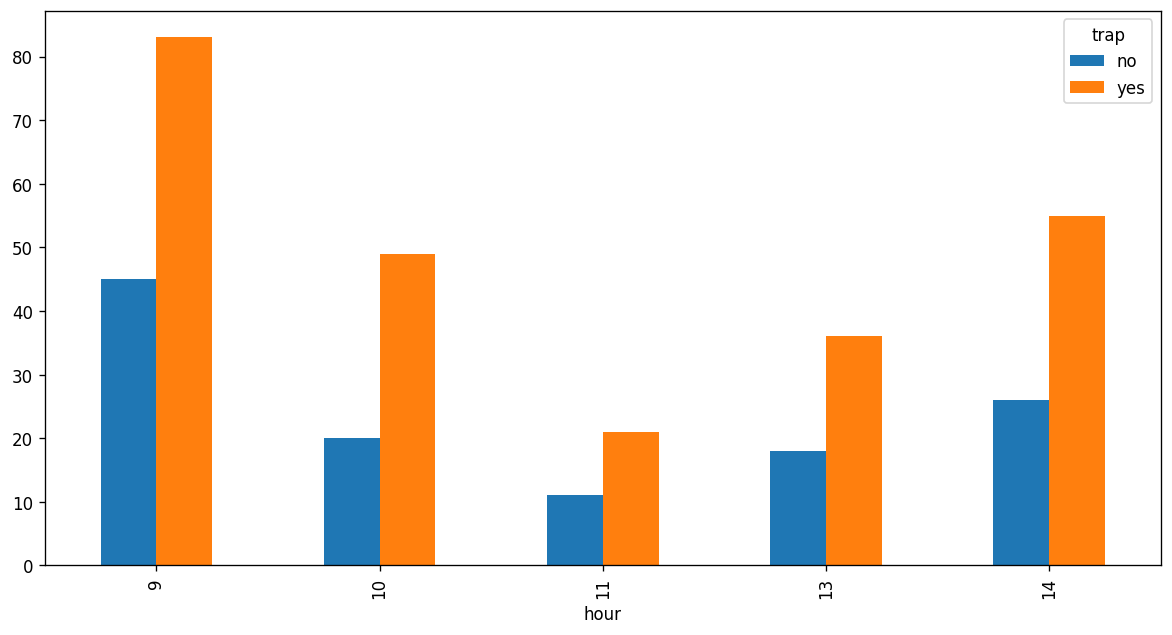

In [17]:
group_by_hour = data[data.trap != ''].groupby(['hour', 'trap'])['hour'].count().rename({'hour': 'count'})
group_by_hour.unstack().plot.bar()

## Analytics by EMA cross speed

<Axes: xlabel='Cross_Speed'>

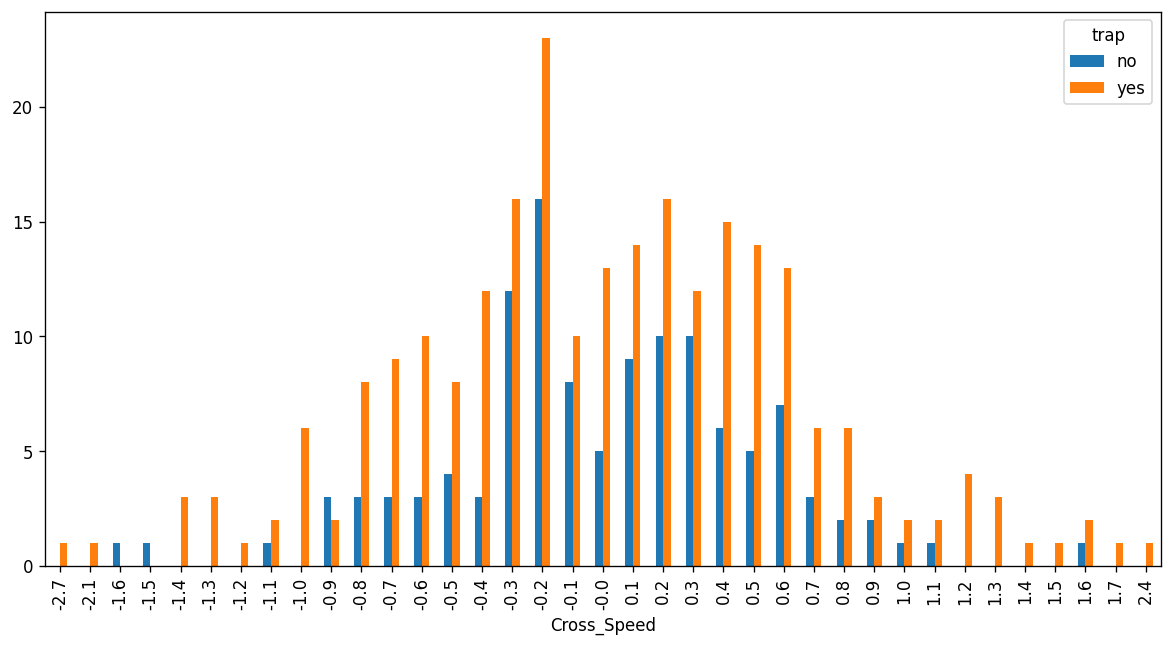

In [18]:
group_by_ema_cross_speed = data[data.trap != ''].groupby(['Cross_Speed', 'trap'])['Cross_Speed'].count().rename({'Cross_Speed': 'count'})
group_by_ema_cross_speed.unstack().plot.bar()

## Analytics by RSI moving

<Axes: xlabel='rsi_moving'>

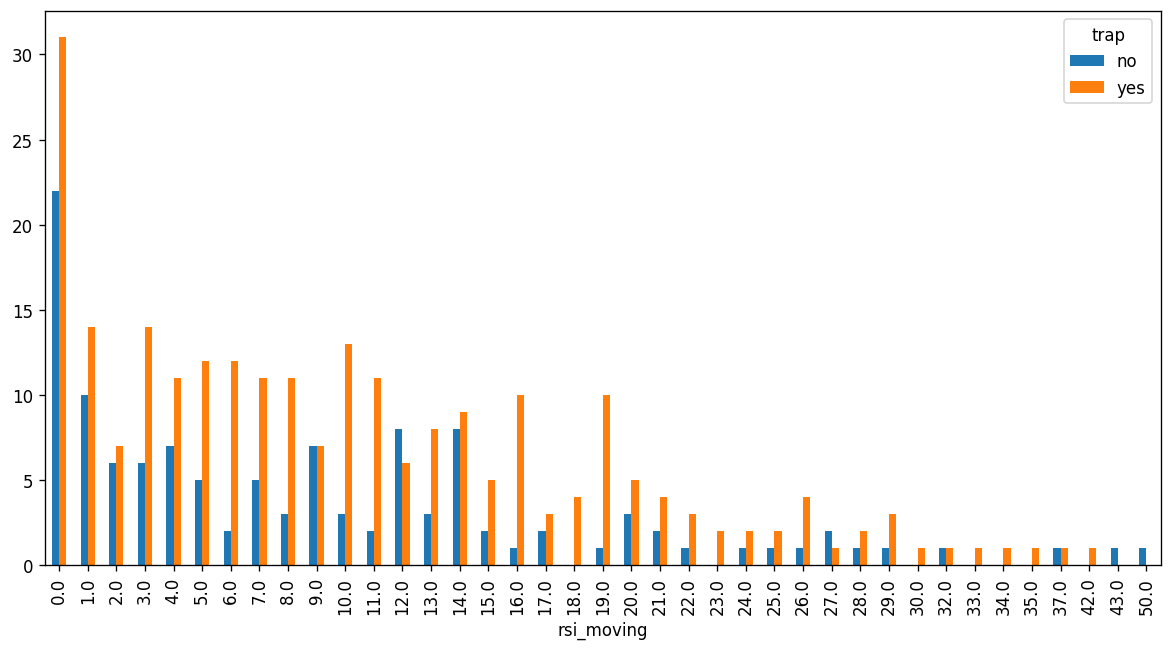

In [19]:
group_by_rsi_moving = data[data.trap != ''].groupby(['rsi_moving', 'trap'])['rsi_moving'].count().rename({'rsi_moving': 'count'})
group_by_rsi_moving.unstack().plot.bar()

## Analytics by min max diff_ema

### Cross up

<Axes: xlabel='min_diff_ema'>

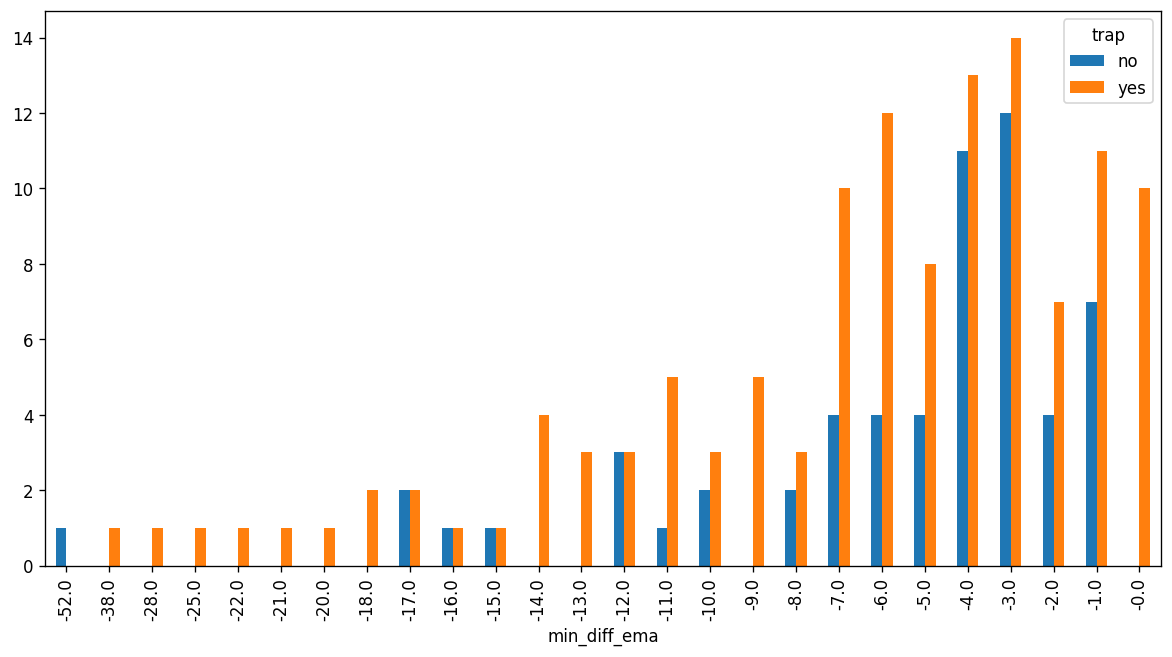

In [20]:
group_by_diff_ema_cross_up = data[(data.trap != '') & (data.ema_fast > data.ema_low)].groupby(['min_diff_ema', 'trap'])['min_diff_ema'].count().rename({'min_diff_ema': 'count'})
group_by_diff_ema_cross_up.unstack().plot.bar()

## Analytics by EMA fast look back (max_emafast_distance)

<Axes: xlabel='max_emafast_distance'>

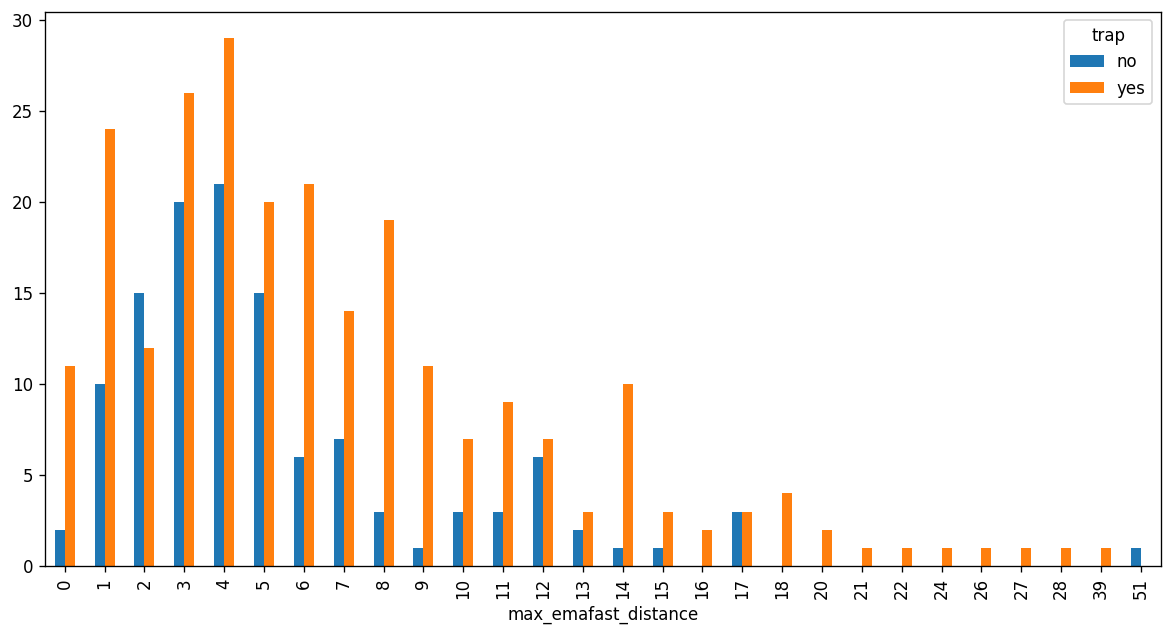

In [21]:
group_by_max_distance= data[data.trap != ''].groupby(['max_emafast_distance', 'trap'])['max_emafast_distance'].count().rename({'max_emafast_distance': 'count'})
group_by_max_distance.unstack().plot.bar()

## Analytics by IBS

<Axes: xlabel='ibs'>

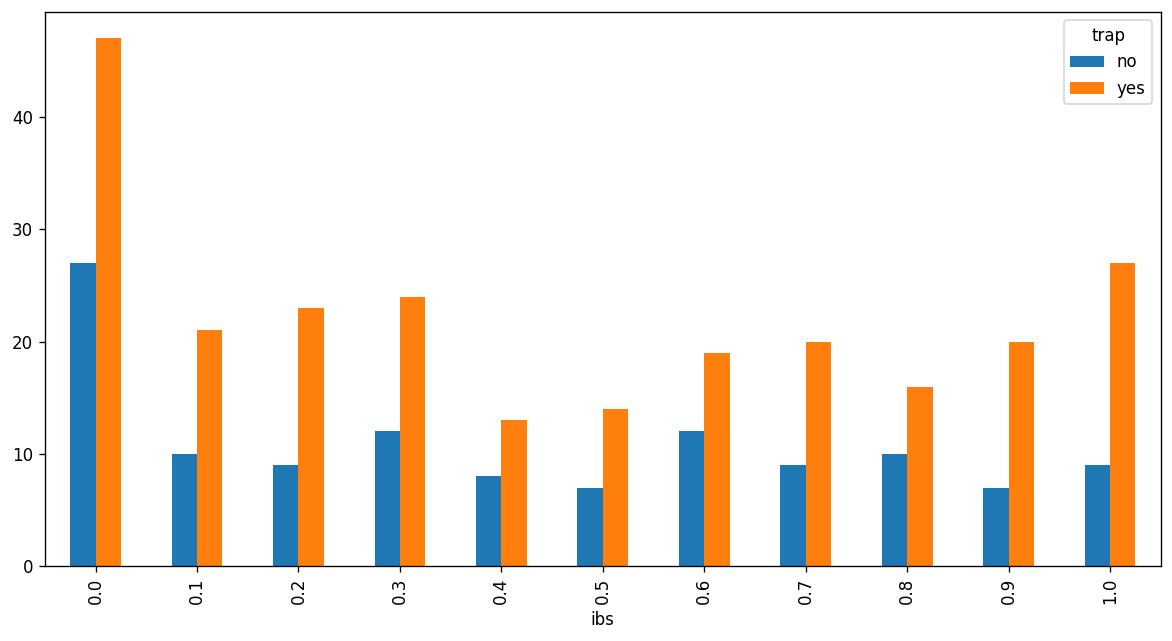

In [22]:
group_by_ibs= data[data.trap != ''].groupby(['ibs', 'trap'])['ibs'].count().rename({'ibs': 'count'})
group_by_ibs.unstack().plot.bar()

<Axes: xlabel='avg_ibs'>

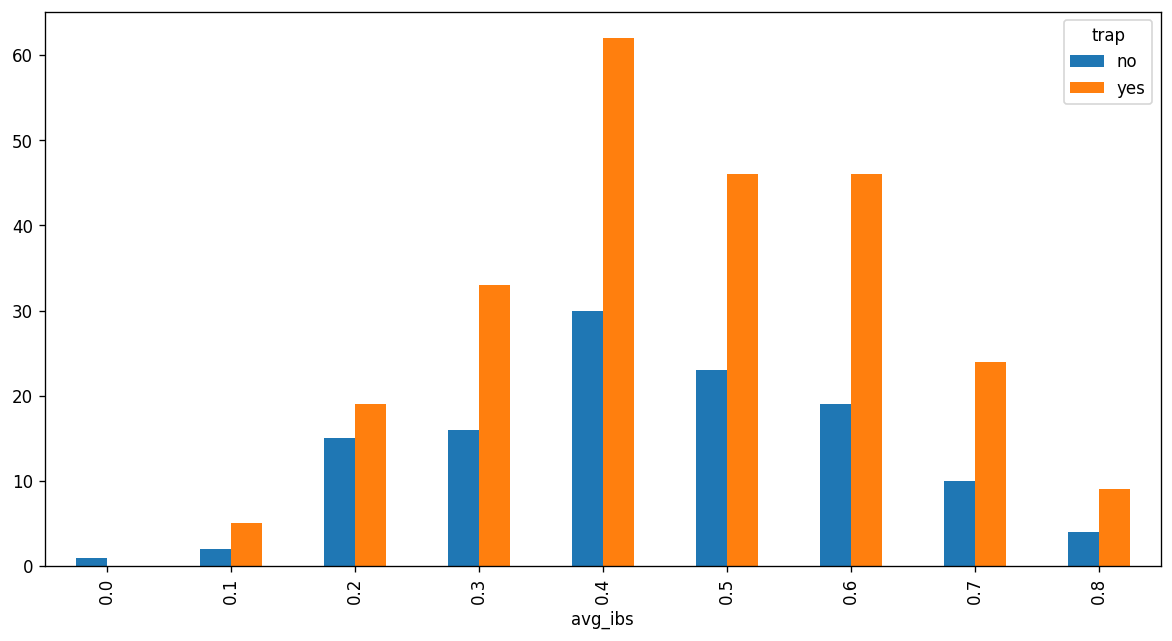

In [23]:
group_by_avg_ibs= data[data.trap != ''].groupby(['avg_ibs', 'trap'])['avg_ibs'].count().rename({'avg_ibs': 'count'})
group_by_avg_ibs.unstack().plot.bar()

## Analytics by avg_diff_ema

<Axes: xlabel='avg_diff_ema'>

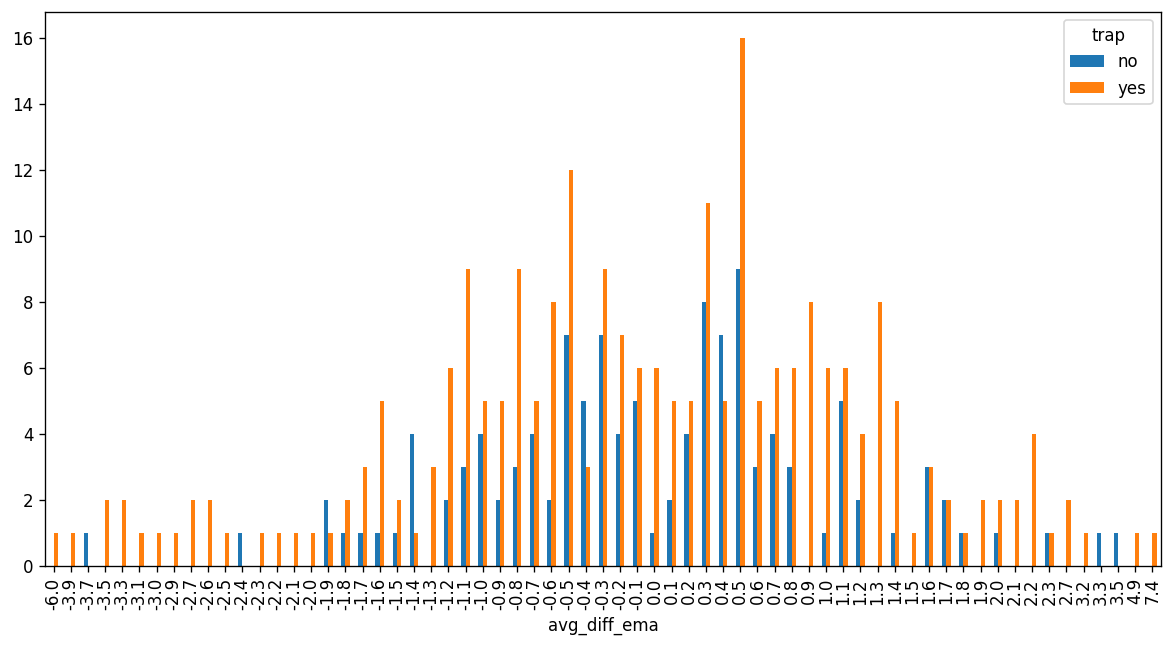

In [24]:
group_by_avg_diff_ema= data[data.trap != ''].groupby(['avg_diff_ema', 'trap'])['avg_diff_ema'].count().rename({'avg_diff_ema': 'count'})
group_by_avg_diff_ema.unstack().plot.bar()

## Analytics by Avg body size

<Axes: xlabel='body_size_on_avg'>

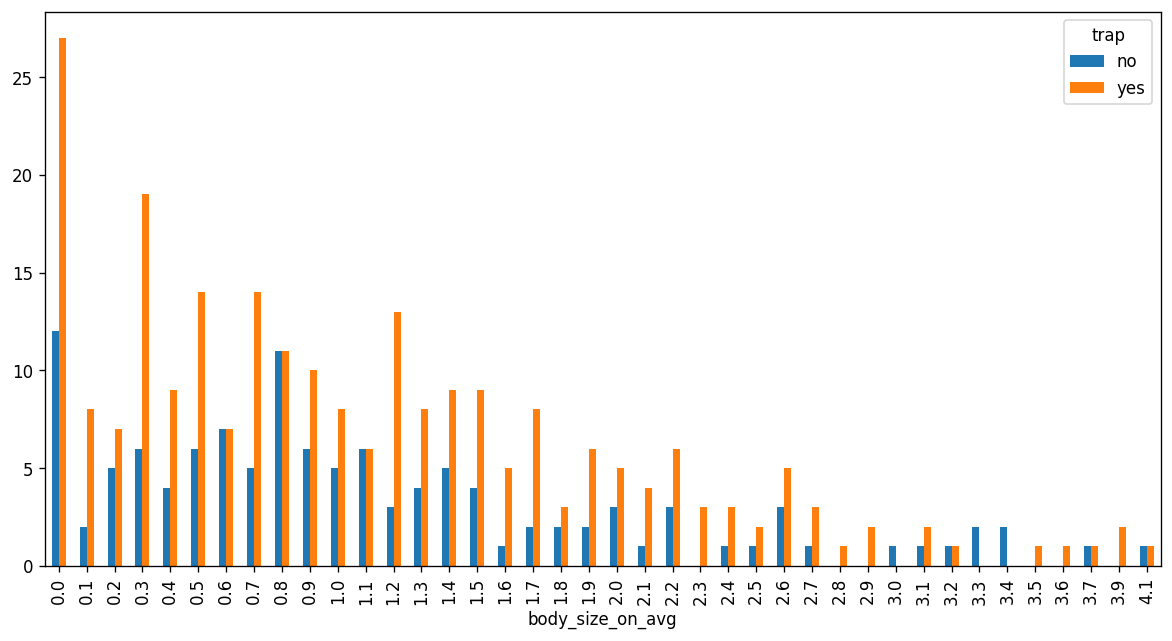

In [25]:
group_by_body_size= data[data.trap != ''].groupby(['body_size_on_avg', 'trap'])['body_size_on_avg'].count().rename({'body_size_on_avg': 'count'})
group_by_body_size.unstack().plot.bar()

## Analytics by Min Max 20

<Axes: xlabel='diff_minmax_20'>

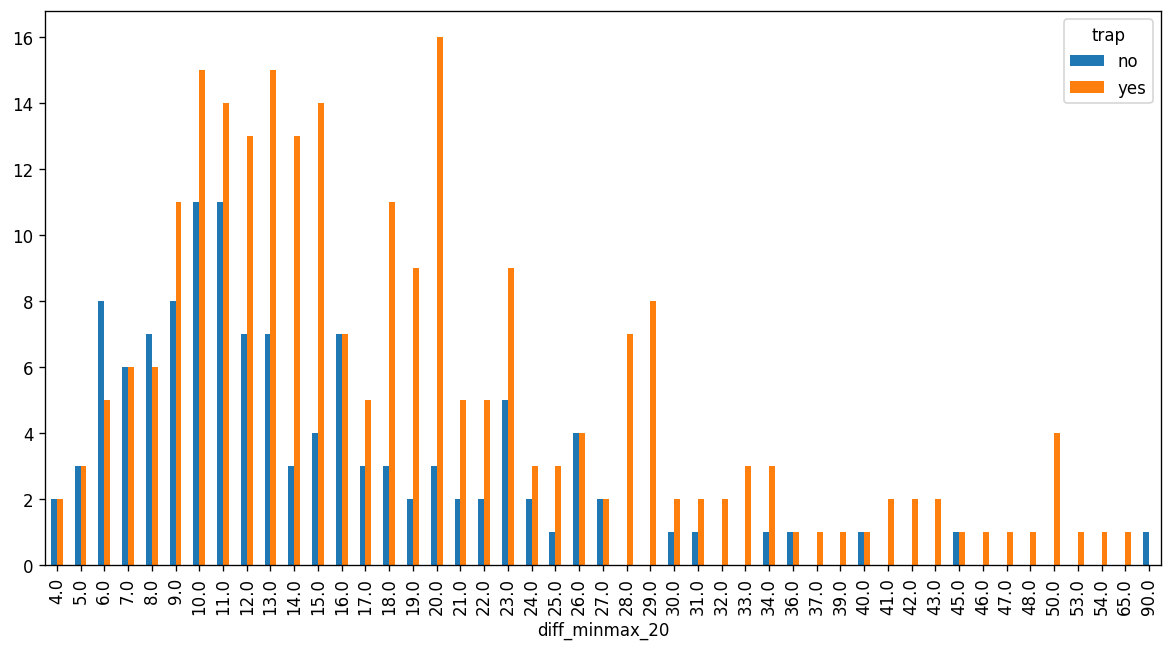

In [26]:
group_by_diff_minmax = data[data.trap != ''].groupby(['diff_minmax_20', 'trap'])['diff_minmax_20'].count().rename({'diff_minmax_20': 'count'})
group_by_diff_minmax.unstack().plot.bar()

## low_momentum analytics

In [27]:
len(data[(data.trap == 'yes') & (data.low_momentum == True)])

24

In [28]:
len(data[(data.trap == 'no') & (data.low_momentum == True)])

18

## Analytics by Volume

<Axes: xlabel='diff_volume'>

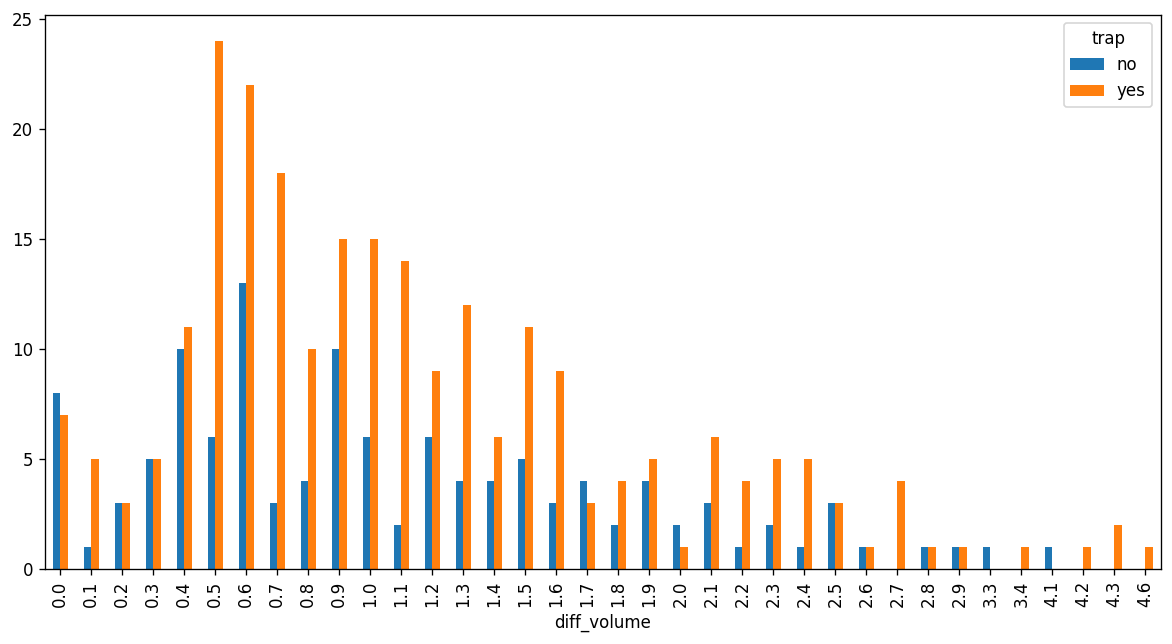

In [29]:
group_by_diff_volume = data[data.trap != ''].groupby(['diff_volume', 'trap'])['diff_volume'].count().rename({'diff_volume': 'count'})
group_by_diff_volume.unstack().plot.bar()

## diff_cema analytics

In [30]:
trap_data = data[data.trap == 'yes']
notrap_data = data[data.trap == 'no']

Text(0, 0.5, 'Nothing')

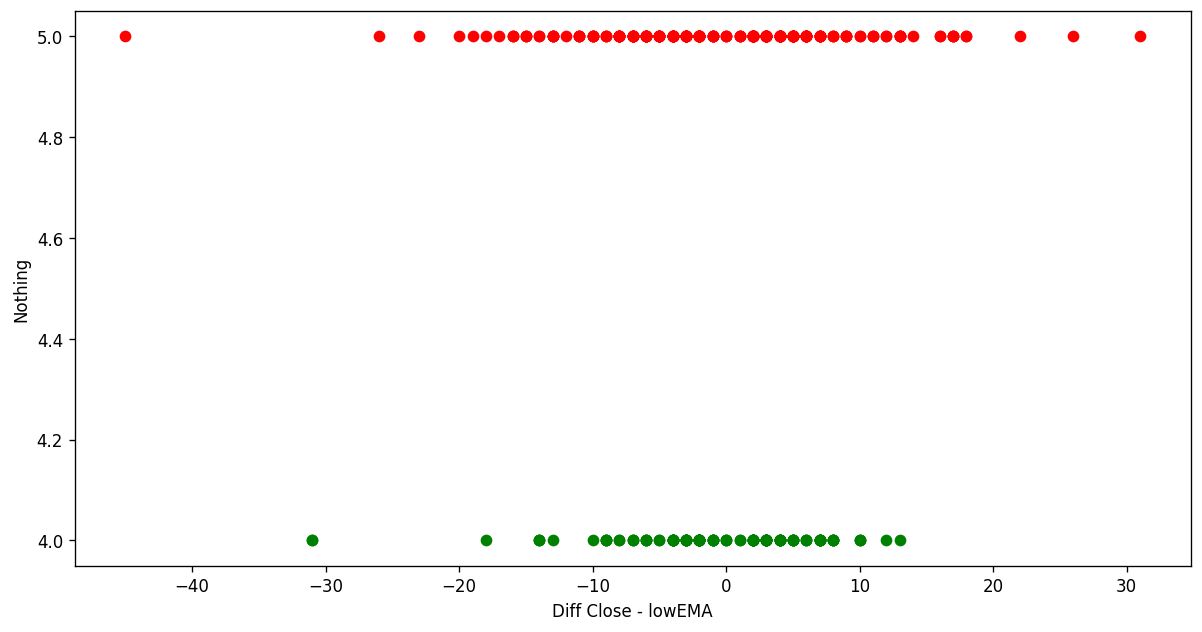

In [31]:
y1 = np.full(len(trap_data['diff_cema']), 5)
y2 = np.full(len(notrap_data['diff_cema']), 4)
plt.scatter(trap_data['diff_cema'], y1, color='red')
plt.scatter(notrap_data['diff_cema'], y2, color='green')
plt.xlabel("Diff Close - lowEMA")
plt.ylabel("Nothing")

<Axes: xlabel='diff_cema'>

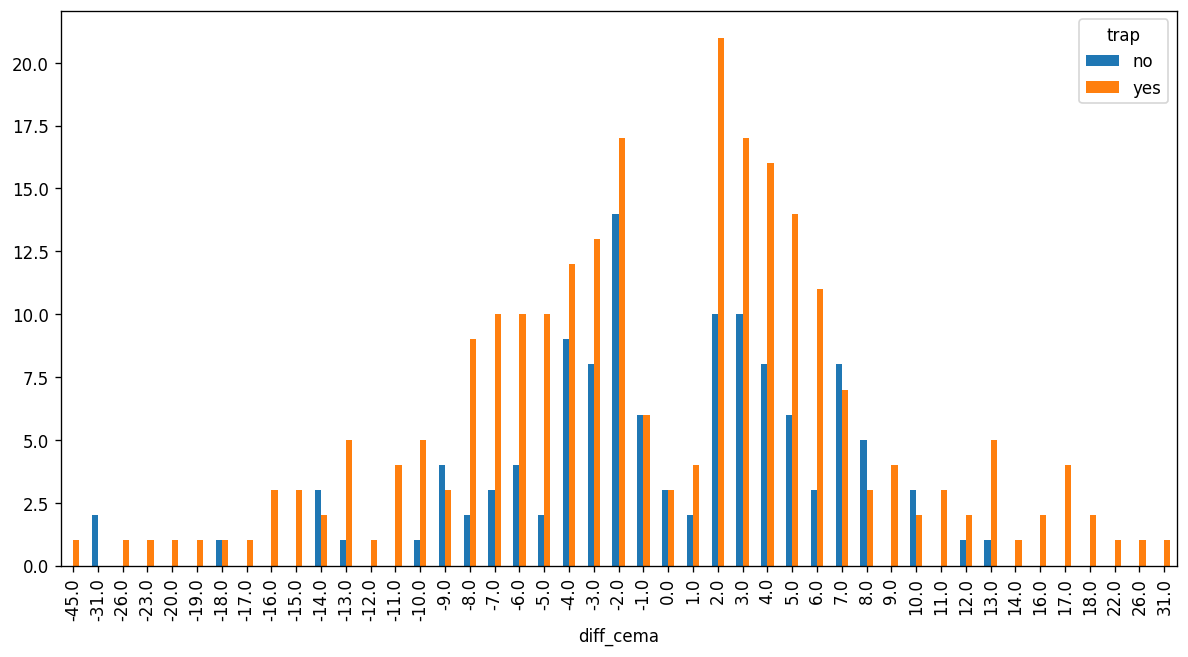

In [32]:
grdp = data[data.trap != ''].groupby(['diff_cema', 'trap'])['diff_cema'].count().rename({'diff_cema': 'count'})
grdp.unstack().plot.bar()

## Analytics by RSI

<Axes: xlabel='RSI'>

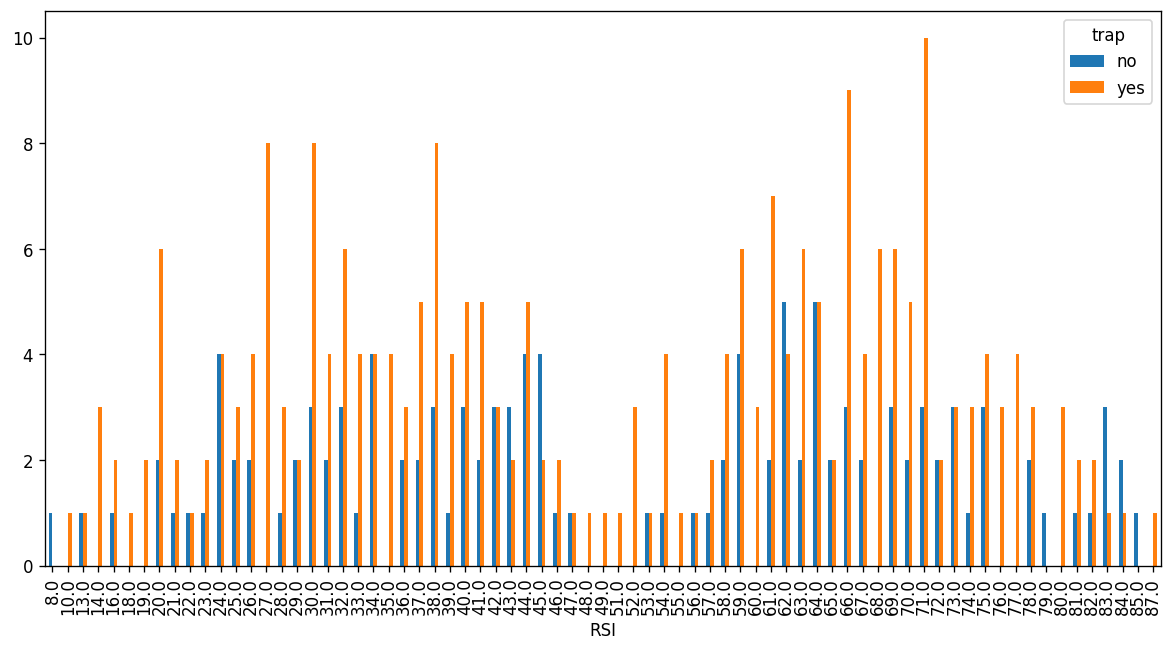

In [33]:
group_by_rsi = data[data.trap != ''].groupby(['RSI', 'trap'])['RSI'].count().rename({'RSI': 'count'})
group_by_rsi.unstack().plot.bar()

### Still RSI but just cross up

<Axes: xlabel='RSI'>

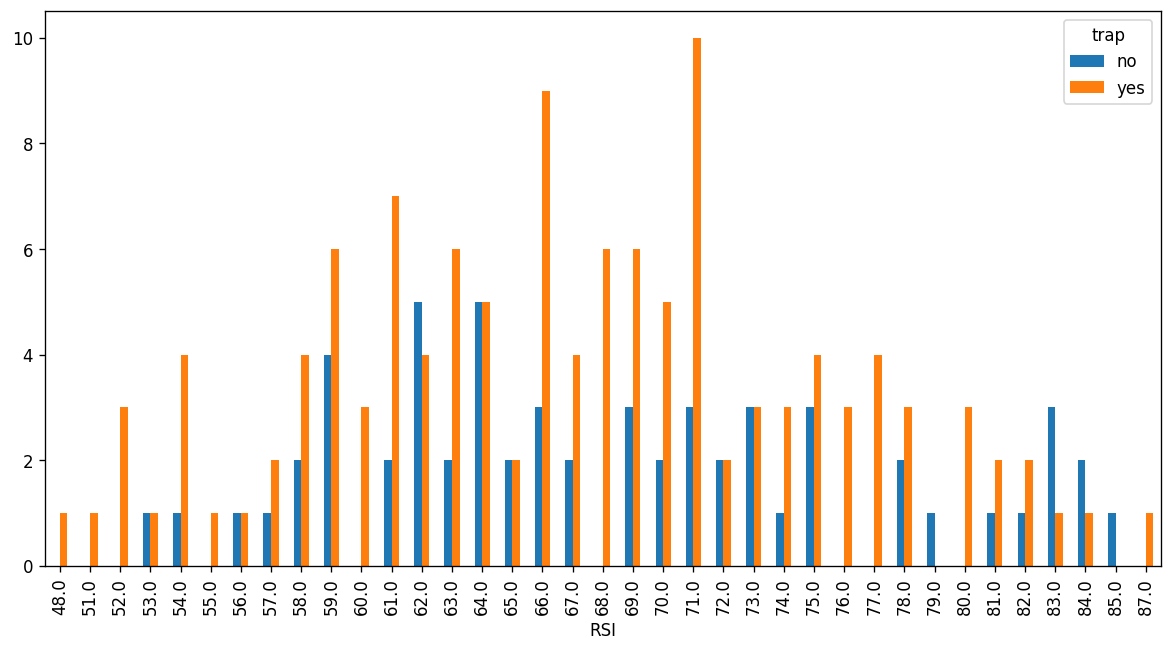

In [34]:
cross_up_group_by_rsi = data[(data.trap != '') & (data.ema_fast > data.ema_low)].groupby(['RSI', 'trap'])['RSI'].count().rename({'RSI': 'count'})
cross_up_group_by_rsi.unstack().plot.bar()

<Axes: xlabel='RSI'>

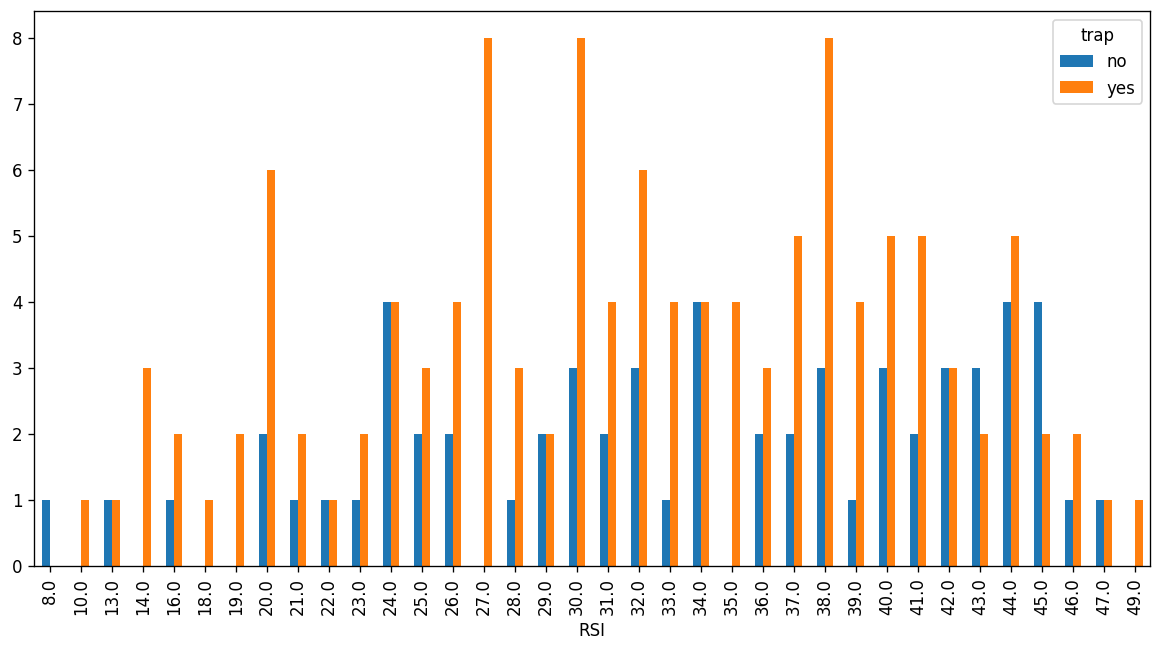

In [35]:
cross_down_group_by_rsi = data[(data.trap != '') & (data.ema_fast < data.ema_low)].groupby(['RSI', 'trap'])['RSI'].count().rename({'RSI': 'count'})
cross_down_group_by_rsi.unstack().plot.bar()